In [1]:
from bowzer import train
from bowzer.utils import view_model_performance
from bowzer.config import ModelSettings
from model_train_configs import prod_config

In [2]:
model_settings = ModelSettings.from_dict(prod_config)

In [3]:
Bowzer = train.BowzerClassifier(model_settings)

Running on device: cuda
Model Settings Info: Final Model Config.


In [4]:
performance = Bowzer.train_eval()

INFO - Model Results will be saved to: model_store/trained_20241028/model_112705
INFO - Training 100 epochs, lr: 1e-05...
INFO - EPOCH 1:
INFO - loss: 3.610829  [   64/ 2576]
INFO - loss: 3.632601  [  704/ 2576]
INFO - loss: 3.563177  [ 1344/ 2576]
INFO - loss: 3.607868  [ 1984/ 2576]
INFO - loss: 3.600953  [  656/ 2576]
INFO - EPOCH 2:
INFO - loss: 3.585716  [   64/ 2576]
INFO - loss: 3.560520  [  704/ 2576]
INFO - loss: 3.618780  [ 1344/ 2576]
INFO - loss: 3.570992  [ 1984/ 2576]
INFO - loss: 3.544011  [  656/ 2576]
INFO - EPOCH 3:
INFO - loss: 3.592691  [   64/ 2576]
INFO - loss: 3.570620  [  704/ 2576]
INFO - loss: 3.590147  [ 1344/ 2576]
INFO - loss: 3.534734  [ 1984/ 2576]
INFO - loss: 3.477833  [  656/ 2576]
INFO - EPOCH 4:
INFO - loss: 3.527726  [   64/ 2576]
INFO - loss: 3.552727  [  704/ 2576]
INFO - loss: 3.506916  [ 1344/ 2576]
INFO - loss: 3.473607  [ 1984/ 2576]
INFO - loss: 3.610552  [  656/ 2576]
INFO - EPOCH 5:
INFO - loss: 3.504997  [   64/ 2576]
INFO - loss: 3.406766

File saved to: model_store/trained_20241028/model_112705/model_epochs_100_performance.json
File saved to: model_store/trained_20241028/model_112705/model_settings.pkl


Loading: model_store/trained_20241028/model_112705/model_epochs_100_performance.json
Plot saved to: model_store/trained_20241028/model_112705/model_epochs_100_performance_plot.jpg


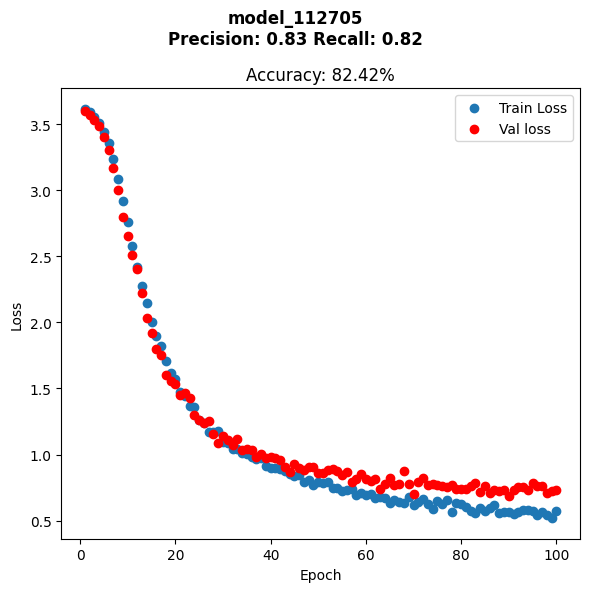

In [6]:
view_model_performance(performance.split('/')[-2], performance, save_fig=True)